In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import statistics
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from warnings import simplefilter
from sklearn.neural_network import MLPClassifier

In [5]:
data = pd.read_csv('dropout-dataset.csv')

In [6]:
data.columns = ['SNO','Gender','SocialCategory','Religion','BPL','Disadvantaged','FreeEducation','Attendance','Homeless','ExamMarks','Disablility','Dropout']
data.drop('SNO',inplace=True, axis=1)

In [7]:
data.shape

(17359, 11)

In [8]:
data.head()

,Gender,SocialCategory,Religion,BPL,Disadvantaged,FreeEducation,Attendance,Homeless,ExamMarks,Disablility,Dropout
0,0,0,0,0,0,0,48,0,51,0,1
1,0,0,0,0,0,0,48,0,48,0,0
2,0,0,0,0,0,0,48,0,86,0,0
3,0,0,0,0,0,0,33,0,33,0,1
4,1,1,0,0,0,0,73,0,96,0,0


In [9]:
n_students, n_features = data.shape

n_passed, _ = data[data['Dropout'] == 1].shape

n_failed, _ = data[data['Dropout'] == 0].shape

grad_rate = (n_passed / n_students) * 100

# Print the results
print ("Total number of students: {}".format(n_students))
print ("Number of features: {}".format(n_features))
print ("Number of students who were left: {}".format(n_passed))
print ("Number of students who were not left: {}".format(n_failed))

Total number of students: 17359
Number of features: 11
Number of students who were left: 3729
Number of students who were not left: 13630


### data preprocessing: one hot representation and data standardization

In [11]:
tdf=pd.get_dummies(data['SocialCategory'],prefix=['SocialCategory'],dtype='float')
tdf1=pd.get_dummies(data['Gender'],prefix=['Gender'],dtype='float')
tdf2=pd.get_dummies(data['Religion'],prefix=['Religion'],dtype='float')
abc=pd.concat([tdf,tdf1,tdf2],axis=1,sort=False)
data['Attendance']=(data['Attendance']-data['Attendance'].mean())/data['Attendance'].std()
data['ExamMarks']=(data['ExamMarks']-data['ExamMarks'].mean())/data['ExamMarks'].std()
data=data.drop(['Gender','Religion','SocialCategory'],axis=1)
x=data.drop('Dropout',axis=1)
y=data['Dropout']
x=pd.concat([abc,x],axis=1,sort=False)

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.4,random_state=1)

# Model implementation
## Since, a student who is likely to drop out classified as ’retained’ is worse than vice-versa, the agenda is to select the model that provides sufficiently low false negatives with reasonable number of false positives. We use weightedaccuracy in which the cost of True Positive Rate is higher than that of True Negative Rate.
## so weighted accuracy=0.7(TP/P) + 0.3(TN/N)

## KNN implementation

In [15]:
simplefilter(action='ignore', category=FutureWarning)

In [199]:
k=[i for i in range(1,50,2)]
wt_accuracy=[]
for l in k:
    knn = KNeighborsClassifier(n_neighbors = l)
    knn.fit(x_train,y_train)
    y_pred=knn.predict(x_test)
    mat=confusion_matrix(y_test, y_pred)
    wt_accuracy.append(0.7*(mat[1][1]/sum(mat[1]))+0.3*(mat[0][0]/sum(mat[0])))

In [200]:
wt_accuracy

[0.667789172252852,
 0.6702011026711419,
 0.6693882499511887,
 0.675763027975864,
 0.6778832433035507,
 0.6730635105107059,
 0.6727368744014801,
 0.6730111475775635,
 0.6654536664280335,
 0.6701088353152282,
 0.6696891136792584,
 0.670821945573045,
 0.6699276476658889,
 0.6758968360962094,
 0.6728848145634407,
 0.6695985198545887,
 0.6706764971131586,
 0.6671541601197504,
 0.6667892931189974,
 0.6670253354035535,
 0.66815816729734,
 0.6689236404882992,
 0.6703282538560948,
 0.6657470550498805,
 0.6664219344161699]

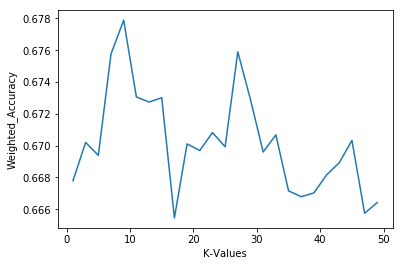

In [201]:
plt.plot(k,wt_accuracy)
plt.xlabel("K-Values")
plt.ylabel("Weighted_Accuracy")

plt.show()

### optimal k value is 9: wt.accuracy=67.7

## hyper parameter tuning using gridsearchcv

In [203]:
model = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(1,50,2)]}
model1 = GridSearchCV(model, param_grid=params,cv=10,scoring='f1')
model1.fit(x_train,y_train)
print("Best Hyper Parameters:",model1.best_params_)

Best Hyper Parameters: {'n_neighbors': 9}


In [204]:
y_pred=model1.predict(x_test)
mat=confusion_matrix(y_test, y_pred)
print(mat)
print((0.7*(mat[1][1]/sum(mat[1]))+0.3*(mat[0][0]/sum(mat[0]))))

[[5203  266]
 [ 648  827]]
0.6778832433035507


# Logistic regression implementation

In [213]:
param_grid = {'C': [0.01, 0.1, 1,10,100] ,'penalty' : ['l1', 'l2']}
model2 = GridSearchCV(LogisticRegression(), param_grid,cv=10,scoring='f1')

In [214]:
model2.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [215]:
model2.best_params_

{'C': 10, 'penalty': 'l1'}

In [216]:
abc=model2.predict(x_test)
mat=confusion_matrix(y_test, abc)
print(mat)
print((0.7*(mat[1][1]/sum(mat[1]))+0.3*(mat[0][0]/sum(mat[0]))))

[[5190  279]
 [ 698  777]]
0.6534413194864118


In [26]:
warnings.filterwarnings('ignore')

## SVM implementation

In [27]:
Cs = [0.01, 0.1, 1, 10,100]
# gammas = [0.01, 0.1, 1]
kernels = ['linear', 'rbf','poly']
param_grid = {'kernel':kernels,'C':Cs}

model3 = GridSearchCV(svm.SVC(gamma='auto'), param_grid,cv=10,scoring='f1')
model3.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [28]:
model3.best_params_

{'C': 100, 'kernel': 'rbf'}

In [29]:
abc=model3.predict(x_test)
mat=confusion_matrix(y_test, abc)
print(mat)
print((0.7*(mat[1][1]/sum(mat[1]))+0.3*(mat[0][0]/sum(mat[0]))))

[[5298  171]
 [ 731  744]]
0.6437046031406604


## Neural network implementation

In [95]:
mlp = MLPClassifier(hidden_layer_sizes = (9,9), activation = 'logistic',batch_size= 200,shuffle=True)
mlp.fit(x_train,y_train)
y_predict = mlp.predict(x_test)
matrix = confusion_matrix(y_test,y_predict)
print("Confusion matrix: \n",matrix)
weighted_accuracy = 0.7*(matrix[1][1]/sum(matrix[1]))+0.3*(matrix[0][0]/sum(matrix[0]))
print("Weighted accuracy : {0:.2f}".format(weighted_accuracy))

Confusion matrix: 
 [[5247  222]
 [ 700  775]]
Weighted accuracy : 0.66


In [ ]:
layers = [(3,),(6,),(9,),(3,3),(6,6),(9,9),(3,3,3),(6,6,6),(9,9,9)]
parameter_space = {
    'hidden_layer_sizes':layers,
        'activation': ['tanh','relu','logistic']
}

In [99]:
model4 = GridSearchCV(mlp, parameter_space, cv=3)
model4.fit(x_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='logistic', alpha=0.0001, batch_size=200, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9, 9), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [(3,), (6,), (9,), (3, 3), (6, 6), (9, 9), (3, 3, 3), (6, 6, 6), (9, 9, 9)], 'activation': ['tanh', 'relu', 'logistic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [100]:
model4.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (9, 9)}

In [101]:
y_predict = model4.predict(x_test)
matrix = confusion_matrix(y_test,y_predict)
print("Confusion matrix: \n",matrix)
weighted_accuracy = 0.7*(matrix[1][1]/sum(matrix[1]))+0.3*(matrix[0][0]/sum(matrix[0]))
print("Weighted accuracy : {0:.2f}".format(weighted_accuracy))

Confusion matrix: 
 [[5194  275]
 [ 600  875]]
Weighted accuracy : 0.70


## Gradient boost implementation

In [30]:
estimators = [x for x in range(20,100,10)]
learning = [1,1.5,2] 

parameter_space = {
    'max_depth':range(3,11),
    'n_estimators':estimators,
    'learning_rate': learning
}

gb = GradientBoostingClassifier()
grid = GridSearchCV(gb, parameter_space, n_jobs=-1, cv = 10)
grid.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(3, 11), 'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90], 'learning_rate': [1, 1.5, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
grid.best_params_

{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 20}

In [32]:
y_predict = grid.predict(x_test)
matrix = confusion_matrix(y_test,y_predict)
print("Confusion matrix: \n",matrix)
weighted_accuracy = 0.7*(matrix[1][1]/sum(matrix[1]))+0.3*(matrix[0][0]/sum(matrix[0]))
print("Weighted accuracy : {0:.2f}".format(weighted_accuracy))

Confusion matrix: 
 [[5167  302]
 [ 571  904]]
Weighted accuracy : 0.71


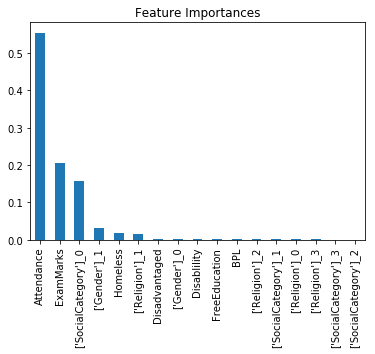

In [33]:
feat_imp = pd.Series(grid.best_estimator_.feature_importances_,x_test.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

# Comparision Of Models

| Model| Optimal parameters | Accuracy(%) |
| :- |: -------------| :-:
| Knn | K = 9 | 67.7 |
| Logistic regression | C = 10 <br> Regularizarion = L1| 65.3 |
| SVM | C = 100 kernel = rbf | 64.3 |
| Neural networks | Number of hidden layers = 2 <br> Number of neurons in each layer = 9 <br> Activation function = tanh | 70 |
| Gradient boosting | Learning rate = 1 <br>Max depth = 3 <br> Estimators = 20 | 71 |



# Different dataset 

In [30]:
new_data=pd.read_csv('new.csv')

In [31]:
new_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


In [33]:
new_data.shape

(395, 31)

In [37]:
n_students, n_features = new_data.shape

n_passed, _ = new_data[new_data['passed'] == 'yes'].shape

n_failed, _ = new_data[new_data['passed'] == 'no'].shape

grad_rate = (n_passed / n_students) * 100

# Print the results
print ("Total number of students: {}".format(n_students))
print ("Number of features: {}".format(n_features))
print ("Number of students who were not left: {}".format(n_passed))
print ("Number of students who left: {}".format(n_failed))

Total number of students: 395
Number of features: 31
Number of students who were not left: 265
Number of students who left: 130


In [38]:
feature_cols = list(new_data.columns[:-1])

# Extract target column 'passed'
target_col = new_data.columns[-1] 

# Show the list of columns
print ("Feature columns:\n{}".format(feature_cols))
print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = new_data[feature_cols]
y_all = new_data[target_col]

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

In [75]:
# Initialize new output DataFrame
output = pd.DataFrame(index = X_all.index)

# Investigate each feature column for the data
for col, col_data in X_all.iteritems():

    # If data type is non-numeric, replace all yes/no values with 1/0
    if col_data.dtype == object:
        col_data = col_data.replace(['yes', 'no'], [1, 0])

    # If data type is categorical, convert to dummy variables
    if col_data.dtype == object:
        # Example: 'school' => 'school_GP' and 'school_MS'
        col_data = pd.get_dummies(col_data, prefix = col)  

    # Collect the revised columns
    output = output.join(col_data)

print ("features:\n{}".format(list(output.columns)))
y_all = y_all.replace(['yes', 'no'], [1, 0])

features:
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [77]:
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(output, y_all, test_size=0.2, random_state=1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 316 samples.
Testing set has 79 samples.


## Knn implementation

In [79]:
model = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(1,50,2)]}
model1 = GridSearchCV(model, param_grid=params,cv=10,scoring='f1')
model1.fit(x_train_new,y_train_new)
print("Best Hyper Parameters:",model1.best_params_)

Best Hyper Parameters: {'n_neighbors': 35}


In [81]:
y_pred=model1.predict(x_test_new)
mat=confusion_matrix(y_test_new, y_pred)
print(mat)
print((0.7*(mat[1][1]/sum(mat[1]))+0.3*(mat[0][0]/sum(mat[0]))))

[[ 1 23]
 [ 0 55]]
0.7124999999999999


## Logistic regression

In [153]:
param_grid = {'C': [0.001,1,10,100] ,'penalty' : ['l1', 'l2']}
model2 = GridSearchCV(LogisticRegression(), param_grid,cv=10,scoring='f1')
model2.fit(x_train_new,y_train_new)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [154]:
model2.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [155]:
abc=model2.predict(x_test_new)
mat=confusion_matrix(y_test_new, abc)
print(mat)
print((0.7*(mat[1][1]/sum(mat[1]))+0.3*(mat[0][0]/sum(mat[0]))))

[[ 0 24]
 [ 0 55]]
0.7


## Svm implementation

In [87]:
Cs = [0.01, 0.1, 1, 10,100]
# gammas = [0.01, 0.1, 1]
kernels = ['linear', 'rbf','poly']
param_grid = {'kernel':kernels,'C':Cs}

model3 = GridSearchCV(svm.SVC(gamma='auto'), param_grid,cv=10,scoring='f1')
model3.fit(x_train_new,y_train_new)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [88]:
model3.best_params_

{'C': 1, 'kernel': 'rbf'}

In [89]:
abc=model3.predict(x_test_new)
mat=confusion_matrix(y_test_new, abc)
print(mat)
print((0.7*(mat[1][1]/sum(mat[1]))+0.3*(mat[0][0]/sum(mat[0]))))

[[ 5 19]
 [ 2 53]]
0.7370454545454544


## Neural network implementation

In [130]:
layers = [(3,),(6,),(9,),(3,3),(6,6),(9,9),(3,3,3),(6,6,6),(9,9,9)]
parameter_space = {
    'hidden_layer_sizes':layers,
    'activation': ['tanh','relu','logistic']
}

In [131]:
model4 = GridSearchCV(mlp, parameter_space, cv=3)
model4.fit(x_train_new, y_train_new)
model4.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (6, 6)}

In [132]:
y_predict = model4.predict(x_test_new)
matrix = confusion_matrix(y_test_new,y_predict)
print("Confusion matrix: \n",matrix)
weighted_accuracy = 0.7*(matrix[1][1]/sum(matrix[1]))+0.3*(matrix[0][0]/sum(matrix[0]))
print("Weighted accuracy : {0:.2f}".format(weighted_accuracy))

Confusion matrix: 
 [[ 3 21]
 [ 1 54]]
Weighted accuracy : 0.72


## Gradient boost implementation

In [135]:
learning_rates = [0.01,0.1,1]
estimators = [x for x in range(10,60)]

parameter_space = {
    'learning_rate':learning_rates,
    'n_estimators':estimators
}

gb= GradientBoostingClassifier()
model5= GridSearchCV(gb, parameter_space, n_jobs=-1, cv = 10)
model5.fit(x_train_new, y_train_new)
model5.best_params_

{'learning_rate': 0.1, 'n_estimators': 28}

In [136]:
y_predict = model5.predict(x_test_new)
matrix = confusion_matrix(y_test_new,y_predict)
print("Confusion matrix: \n",matrix)
weighted_accuracy = 0.7*(matrix[1][1]/sum(matrix[1]))+0.3*(matrix[0][0]/sum(matrix[0]))
print("Weighted accuracy : {0:.2f}".format(weighted_accuracy))

Confusion matrix: 
 [[10 14]
 [ 7 48]]
Weighted accuracy : 0.74


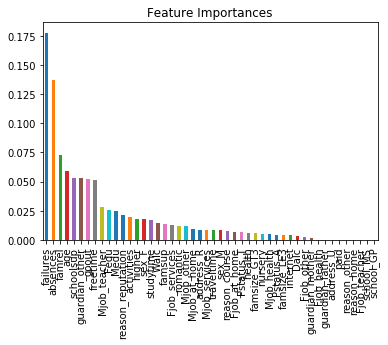

In [196]:
feat_imp = pd.Series(model5.best_estimator_.feature_importances_,x_test_new.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

# Comparision Of Models

| Model| Optimal parameters | Accuracy(%) |
| :- |: -------------| :-:
| Knn | K = 35 | 71.2 |
| Logistic regression | C = 0.001 <br> Regularizarion = L2| 70 |
| SVM | C = 1 kernel = rbf | 73.7 |
| Neural networks | Number of hidden layers = 2 <br> Number of neurons in each layer = 6 <br> Activation function = relu | 72 |
| Gradient boosting | Learning rate = 0.1 <br> Estimators = 28 | 74 |

